This capstone project focuses on a basic form of Natural Language Processing (NLP): Sentiment Analysis. We used two different neural networks in Keras to classify Amazon book reviews as either positive or negative, and to compare the performance of the two networks. We used two small samples of positive and negative book reviews from Amazon as our data.

###  Get and explore dataset

In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re

In [2]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [3]:
positive_file = "positive.txt"
negative_file = "negative.txt"

In [4]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
  return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [5]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [6]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
from keras.utils import to_categorical
labels  = to_categorical(to_numeric_label(word_labels))

Mean Review length: 4
Standard Deviation: 2


{'whiskers': [<matplotlib.lines.Line2D at 0x24a134c2310>,
 'caps': [<matplotlib.lines.Line2D at 0x24a134c29d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x24a134a7f70>],
 'medians': [<matplotlib.lines.Line2D at 0x24a13b630d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x24a13b63430>],
 'means': []}

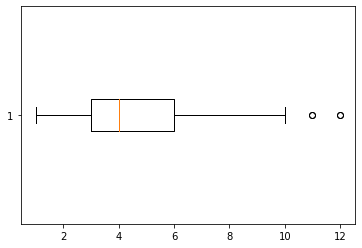

In [7]:
# - Calculate and report the mean review size, its standard deviation and create a boxplot.

# calculate mean review size
lengths = [len(i.split()) for i in data]
mean_review_size = round(np.mean(lengths))

print("Mean Review length:", mean_review_size)
print("Standard Deviation:", round(np.std(lengths))) 

plt.boxplot(lengths, vert=False)

As we can observe from the plot above, the mean length of review sentiments is 4 and 75% of them are shorter than 6 words.

In [8]:
# - Calculate the number of unique words in the dataset
words = " ".join(data).split()
print("The number of unique words in the dataset: ", len(np.unique(words)))

The number of unique words in the dataset:  2559


In [9]:
# Do not modify - Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


## Pre-processing

In [10]:
# Pre-processing
from keras.utils import pad_sequences

X = pad_sequences(tokenized_data, padding='post', maxlen=mean_review_size)

In [11]:
# Write some code to split the data into a training and test set. Make sure you shuffle the data. Use 20% for the test set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1434, 4) (1434, 2)
(359, 4) (359, 2)


In [12]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# The following function
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also prints the confusion matrix. 
# - uses the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

def assess_model(model, X_test, y_test):      
    y_pred = model.predict(X_test, verbose=0)
    precision = precision_score(to_class(y_test), to_class(y_pred))
    recall = recall_score(to_class(y_test), to_class(y_pred))
    f1 = f1_score(to_class(y_test), to_class(y_pred))
    
    print("precision score: " , round(precision,4))
    print("recall score: ", round(recall,4))   
    print("F1 score: ", round(f1,4))
    print("confusion matrix: \n", confusion_matrix(to_class(y_test), to_class(y_pred)))

In [13]:
def report_score(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    print("Test loss: ", round(score[0],4))
    print("Test accuracy : ", round(score[1],4))

## Build and tune model

Define network architecture

In [14]:
from keras import models
from keras import layers

def build_model(output_dim):
    """
    function  builds and compiles a model;
    parameters: 
            output_dim - dimension of a vector space in Embedding layer """
    
    model = models.Sequential()
    model.add(layers.Embedding(vocab_size, output_dim))
    model.add(layers.SpatialDropout1D(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.LSTM(32))
    model.add(layers.Dense(2, activation='softmax'))
    
    model.summary()
    # compiling the model
    model.compile(optimizer = "adam",loss = "binary_crossentropy", metrics = ["accuracy"])
    return model
    

In [15]:
batch_size = 10
epoch_num = 5

In [16]:
# model with output dim equals 10
model_10 = build_model(10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          25600     
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 10)         0         
 ropout1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, None, 10)         40        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 32)                5504      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 31,210
Trainable params: 31,190
Non-traina

Train model

In [17]:
history_10 = model_10.fit(X_train, y_train,
                    epochs= epoch_num,
                    batch_size = batch_size,
                    validation_split=0.2)

Epoch 1/5
115/115 [==============================] - 5s 11ms/step - loss: 0.6907 - accuracy: 0.5310 - val_loss: 0.6910 - val_accuracy: 0.5923
Epoch 2/5
115/115 [==============================] - 1s 5ms/step - loss: 0.6720 - accuracy: 0.5902 - val_loss: 0.6779 - val_accuracy: 0.6272
Epoch 3/5
115/115 [==============================] - 1s 5ms/step - loss: 0.6612 - accuracy: 0.5920 - val_loss: 0.6590 - val_accuracy: 0.6307
Epoch 4/5
115/115 [==============================] - 1s 6ms/step - loss: 0.6462 - accuracy: 0.5990 - val_loss: 0.6394 - val_accuracy: 0.6481
Epoch 5/5
115/115 [==============================] - 1s 5ms/step - loss: 0.6429 - accuracy: 0.6051 - val_loss: 0.6248 - val_accuracy: 0.6376


In [18]:
# model with output dim in Embedding layer equals 25
model_25 = build_model(25)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 25)          64000     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, None, 25)         0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_1 (Batc  (None, None, 25)         100       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 32)                7424      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 71,590
Trainable params: 71,540
Non-trai

In [20]:
history_25 = model_25.fit(X_train, y_train,
                    epochs= epoch_num,
                    batch_size = batch_size,
                    validation_split=0.2)

Epoch 1/5
115/115 [==============================] - 4s 10ms/step - loss: 0.6877 - accuracy: 0.5301 - val_loss: 0.6900 - val_accuracy: 0.5923
Epoch 2/5
115/115 [==============================] - 1s 6ms/step - loss: 0.6723 - accuracy: 0.5728 - val_loss: 0.6741 - val_accuracy: 0.6098
Epoch 3/5
115/115 [==============================] - 1s 5ms/step - loss: 0.6577 - accuracy: 0.5963 - val_loss: 0.6548 - val_accuracy: 0.6132
Epoch 4/5
115/115 [==============================] - 1s 6ms/step - loss: 0.6477 - accuracy: 0.5990 - val_loss: 0.6328 - val_accuracy: 0.6376
Epoch 5/5
115/115 [==============================] - 1s 6ms/step - loss: 0.6419 - accuracy: 0.6094 - val_loss: 0.6246 - val_accuracy: 0.6481


In [21]:
# model with output dim in Embedding layer equals 50
model_50 = build_model(50)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 50)          128000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, None, 50)         0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_3 (Batc  (None, None, 50)         200       
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (None, 32)                10624     
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 138,890
Trainable params: 138,790
Non-tr

In [22]:
history_50 = model_50.fit(X_train, y_train,
                    epochs= epoch_num,
                    batch_size = batch_size,
                    validation_split=0.2)

Epoch 1/5
115/115 [==============================] - 4s 11ms/step - loss: 0.6888 - accuracy: 0.5440 - val_loss: 0.6899 - val_accuracy: 0.6028
Epoch 2/5
115/115 [==============================] - 1s 6ms/step - loss: 0.6712 - accuracy: 0.6016 - val_loss: 0.6802 - val_accuracy: 0.6516
Epoch 3/5
115/115 [==============================] - 1s 6ms/step - loss: 0.6595 - accuracy: 0.5937 - val_loss: 0.6593 - val_accuracy: 0.6341
Epoch 4/5
115/115 [==============================] - 1s 6ms/step - loss: 0.6501 - accuracy: 0.5876 - val_loss: 0.6403 - val_accuracy: 0.6446
Epoch 5/5
115/115 [==============================] - 1s 7ms/step - loss: 0.6414 - accuracy: 0.6207 - val_loss: 0.6268 - val_accuracy: 0.6411


In [23]:
# model with output dim in Embedding layer equals 100
model_100 = build_model(100)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         256000    
                                                                 
 spatial_dropout1d_4 (Spatia  (None, None, 100)        0         
 lDropout1D)                                                     
                                                                 
 batch_normalization_4 (Batc  (None, None, 100)        400       
 hNormalization)                                                 
                                                                 
 lstm_4 (LSTM)               (None, 32)                17024     
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 273,490
Trainable params: 273,290
Non-tr

In [24]:
history_100 = model_100.fit(X_train, y_train,
                    epochs= epoch_num,
                    batch_size = batch_size,
                    validation_split=0.2)

Epoch 1/5
115/115 [==============================] - 4s 13ms/step - loss: 0.6901 - accuracy: 0.5458 - val_loss: 0.6872 - val_accuracy: 0.5679
Epoch 2/5
115/115 [==============================] - 1s 7ms/step - loss: 0.6678 - accuracy: 0.5763 - val_loss: 0.6760 - val_accuracy: 0.6028
Epoch 3/5
115/115 [==============================] - 1s 7ms/step - loss: 0.6638 - accuracy: 0.5929 - val_loss: 0.6544 - val_accuracy: 0.6376
Epoch 4/5
115/115 [==============================] - 1s 7ms/step - loss: 0.6504 - accuracy: 0.5894 - val_loss: 0.6340 - val_accuracy: 0.6272
Epoch 5/5
115/115 [==============================] - 1s 7ms/step - loss: 0.6424 - accuracy: 0.6181 - val_loss: 0.6166 - val_accuracy: 0.6516


Examine performance of model to find best value for embedding layer output dimension paramener.

In [27]:
print("Model with output_num=10:\n")
assess_model(model_10, X_test, y_test)  
report_score(model_10, X_test, y_test)

Model with output_num=10:

precision score:  0.5667
recall score:  0.7432
F1 score:  0.643
confusion matrix: 
 [[ 72 104]
 [ 47 136]]
Test loss:  0.6625
Test accuracy :  0.5794


In [28]:
print("Model with output_num=25:\n")
assess_model(model_25, X_test, y_test)  
report_score(model_25, X_test, y_test)

Model with output_num=25:

precision score:  0.5587
recall score:  0.7541
F1 score:  0.6419
confusion matrix: 
 [[ 67 109]
 [ 45 138]]
Test loss:  0.6641
Test accuracy :  0.571


In [29]:
print("Model with output_num=50:\n")
assess_model(model_50, X_test, y_test)  
report_score(model_50, X_test, y_test)

Model with output_num=50:

precision score:  0.5783
recall score:  0.7268
F1 score:  0.6441
confusion matrix: 
 [[ 79  97]
 [ 50 133]]
Test loss:  0.6615
Test accuracy :  0.5905


In [30]:
print("Model with output_num=100:\n")
assess_model(model_100, X_test, y_test)  
report_score(model_100, X_test, y_test)

Model with output_num=100:

precision score:  0.5833
recall score:  0.765
F1 score:  0.6619
confusion matrix: 
 [[ 76 100]
 [ 43 140]]
Test loss:  0.6614
Test accuracy :  0.6017


Compare model perfomance for different values of output_dim paremeter in the embedding layer.

In [31]:
from tabulate import tabulate

# assign data
data = [ ["10", "0.5615", "0.7978", "0.6591", "0.5794"],
         ["25", "0.6073", "0.7268", "0.6617", "0.6212"],
         ["50", "0.5971", "0.6721", "0.6324", "0.6017"],
         ["100", "0.583", "0.7486", "0.6555", "0.5989"]
]

# create header
col_names = ["output_dim", "precision score", "recall score", "F1 score", "accuracy"] 

# display table
print(tabulate(data, headers=col_names, tablefmt="grid"))

+--------------+-------------------+----------------+------------+------------+
|   output_dim |   precision score |   recall score |   F1 score |   accuracy |
+==============+===================+================+============+============+
|           10 |            0.5615 |         0.7978 |     0.6591 |     0.5794 |
+--------------+-------------------+----------------+------------+------------+
|           25 |            0.6073 |         0.7268 |     0.6617 |     0.6212 |
+--------------+-------------------+----------------+------------+------------+
|           50 |            0.5971 |         0.6721 |     0.6324 |     0.6017 |
+--------------+-------------------+----------------+------------+------------+
|          100 |            0.583  |         0.7486 |     0.6555 |     0.5989 |
+--------------+-------------------+----------------+------------+------------+


The best perfomance (highest accuracy and highest F1 score) model has for output_dim equals 25. Below is a plot of accuracy and loss values of the model while training.

 We choose final model with output_dim=25: model_25. Run this model with epoch = 40 to examine model loss and accuracy.
 

In [32]:
batch_size = 10
epoch_num = 40
history = model_25.fit(X_train, y_train,
                    epochs= epoch_num,
                    batch_size = batch_size,
                    validation_split=0.2)

Epoch 1/40
115/115 [==============================] - 1s 6ms/step - loss: 0.6427 - accuracy: 0.5955 - val_loss: 0.6201 - val_accuracy: 0.6341
Epoch 2/40
115/115 [==============================] - 1s 6ms/step - loss: 0.6343 - accuracy: 0.6138 - val_loss: 0.6260 - val_accuracy: 0.6516
Epoch 3/40
115/115 [==============================] - 1s 6ms/step - loss: 0.6316 - accuracy: 0.6094 - val_loss: 0.6219 - val_accuracy: 0.6481
Epoch 4/40
115/115 [==============================] - 1s 5ms/step - loss: 0.6330 - accuracy: 0.6173 - val_loss: 0.6228 - val_accuracy: 0.6516
Epoch 5/40
115/115 [==============================] - 1s 6ms/step - loss: 0.6274 - accuracy: 0.6129 - val_loss: 0.6208 - val_accuracy: 0.6551
Epoch 6/40
115/115 [==============================] - 1s 7ms/step - loss: 0.6216 - accuracy: 0.6216 - val_loss: 0.6269 - val_accuracy: 0.6516
Epoch 7/40
115/115 [==============================] - 1s 6ms/step - loss: 0.6210 - accuracy: 0.6373 - val_loss: 0.6361 - val_accuracy: 0.6551
Epoch 

Plot graphs for accuracy and loss

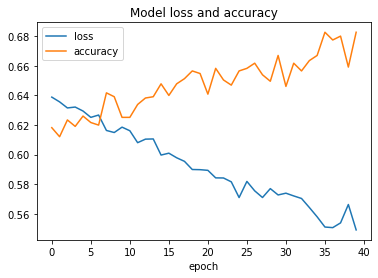

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Model loss and accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'])
plt.show()

 After around 30 epochs the loss and accuracy values stop improving much. We wil train model for 30 epochs.  

In [44]:
epoch_num = 30
batch_size = 10
history = model_25.fit(X_train, y_train,
                    epochs= epoch_num,
                    batch_size = batch_size,
                    validation_split=0.2)

Epoch 1/30
115/115 [==============================] - 1s 6ms/step - loss: 0.5221 - accuracy: 0.7044 - val_loss: 0.7745 - val_accuracy: 0.6237
Epoch 2/30
115/115 [==============================] - 1s 6ms/step - loss: 0.5189 - accuracy: 0.6940 - val_loss: 0.7712 - val_accuracy: 0.6341
Epoch 3/30
115/115 [==============================] - 1s 6ms/step - loss: 0.5218 - accuracy: 0.6905 - val_loss: 0.7697 - val_accuracy: 0.6167
Epoch 4/30
115/115 [==============================] - 1s 6ms/step - loss: 0.5171 - accuracy: 0.6983 - val_loss: 0.7867 - val_accuracy: 0.6132
Epoch 5/30
115/115 [==============================] - 1s 6ms/step - loss: 0.5217 - accuracy: 0.6888 - val_loss: 0.7859 - val_accuracy: 0.6167
Epoch 6/30
115/115 [==============================] - 1s 6ms/step - loss: 0.5171 - accuracy: 0.6914 - val_loss: 0.7834 - val_accuracy: 0.6063
Epoch 7/30
115/115 [==============================] - 1s 6ms/step - loss: 0.5187 - accuracy: 0.6966 - val_loss: 0.8000 - val_accuracy: 0.6202
Epoch 

In [50]:
assess_model(model_25, X_test, y_test)  
report_score(model_25, X_test, y_test)

precision score:  0.5697
recall score:  0.7814
F1 score:  0.659
confusion matrix: 
 [[ 68 108]
 [ 40 143]]
Test loss:  0.9219
Test accuracy :  0.5877


We only got an accuracy of 59%, which is very low. However, we couldn't expect to get good results given so few examples to train the model.

Now we will build and train a fully convolutional model to do the same task.

In [97]:
model_fc = models.Sequential()
model_fc.add(layers.Embedding(vocab_size, 32, input_length=4))
model_fc.add(layers.SpatialDropout1D(0.2))
model_fc.add(layers.BatchNormalization())
model_fc.add(layers.Flatten())
model_fc.add(layers.Dense(32, activation='relu'))
model_fc.add(layers.Dense(2, activation='softmax'))
    
model_fc.summary()
# compiling the model
model_fc.compile(optimizer = "adam",loss = "binary_crossentropy", metrics = ["accuracy"])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 4, 32)             81920     
                                                                 
 spatial_dropout1d_11 (Spati  (None, 4, 32)            0         
 alDropout1D)                                                    
                                                                 
 batch_normalization_11 (Bat  (None, 4, 32)            128       
 chNormalization)                                                
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 32)                4128      
                                                                 
 dense_14 (Dense)            (None, 2)               

In [128]:
history_fc= model_fc.fit(X_train, y_train,
                    epochs= 20,
                    batch_size = batch_size,
                    validation_split=0.2)

Epoch 1/20
115/115 [==============================] - 0s 4ms/step - loss: 0.5201 - accuracy: 0.6853 - val_loss: 0.9299 - val_accuracy: 0.5993
Epoch 2/20
115/115 [==============================] - 0s 4ms/step - loss: 0.5182 - accuracy: 0.7018 - val_loss: 0.9338 - val_accuracy: 0.5923
Epoch 3/20
115/115 [==============================] - 0s 4ms/step - loss: 0.5184 - accuracy: 0.6888 - val_loss: 0.9452 - val_accuracy: 0.6028
Epoch 4/20
115/115 [==============================] - 0s 4ms/step - loss: 0.5079 - accuracy: 0.7001 - val_loss: 0.9283 - val_accuracy: 0.5958
Epoch 5/20
115/115 [==============================] - 0s 4ms/step - loss: 0.5225 - accuracy: 0.6966 - val_loss: 0.9186 - val_accuracy: 0.5923
Epoch 6/20
115/115 [==============================] - 0s 4ms/step - loss: 0.5244 - accuracy: 0.6853 - val_loss: 0.9473 - val_accuracy: 0.6341
Epoch 7/20
115/115 [==============================] - 1s 5ms/step - loss: 0.5193 - accuracy: 0.6905 - val_loss: 0.9426 - val_accuracy: 0.5993
Epoch 

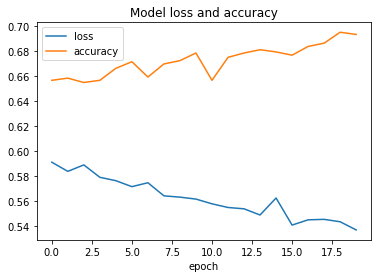

In [100]:
plt.plot(history_fc.history['loss'])
plt.plot(history_fc.history['accuracy'])
plt.title('Model loss and accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'])
plt.show()

In [101]:
assess_model(model_fc, X_test, y_test)  
report_score(model_fc, X_test, y_test)

precision score:  0.5697
recall score:  0.7814
F1 score:  0.659
confusion matrix: 
 [[ 68 108]
 [ 40 143]]
Test loss:  0.8082
Test accuracy :  0.5877


The accuracy of the model is only 59% but it is better for model with LSTM. They both models perform poorly due to the small number of training samples.

##  Make a prediction

In [106]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay", "horrible", "very very good"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
maxlen = 4
padded = pad_sequences(tokenized, padding='post', maxlen=maxlen)

# Supply this data to each of your models and see how it does. 
# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.

y_pred = model_25(padded)
print("model_25 :",to_word_label(y_pred))

y_pred = model_fc(padded)
print("model_fc: ",to_word_label(y_pred))

model_25 : ['negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive']
model_fc:  ['negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive']


The both models yielded similar predictions for all reviews except the second. None of the models perfomed well due to a small number of training samples but it seems that 
Convolutional model is more suited for sentimets analysis.